In [ ]:
!pip install d2l==1.0.0-beta0

Khi xử lý ảnh, ta thường muốn giảm dần độ phân giải không gian của các biểu diễn ẩn, tổng hợp thông tin lại để khi càng đi sâu vào mạng, vùng tiếp nhận (ở đầu vào) ảnh hưởng đến mỗi nút ẩn càng lớn.

Nhiệm vụ cuối cùng thường là trả lời một câu hỏi nào đó về toàn bộ tấm ảnh, ví dụ như: trong ảnh có mèo không? Vậy nên các nút của tầng cuối cùng thường cần phải chịu ảnh hưởng của toàn bộ đầu vào. Bằng cách dần gộp thông tin lại để tạo ra các ánh xạ đặc trưng thưa dần, ta sẽ học được một biểu diễn toàn cục, trong khi vẫn có thể giữ nguyên toàn bộ lợi thế đến từ các tầng tích chập xử lý trung gian.

Hơn nữa, khi phát hiện các đặc trưng cấp thấp như cạnh (được thảo luận tại Section 6.2), ta thường muốn cách biểu diễn này bất biến với phép tịnh tiến trong một chừng mực nào đó. Ví dụ, nếu ta lấy ảnh X với một ranh giới rõ rệt giữa màu đen và màu trắng và dịch chuyển toàn bộ tấm ảnh sang phải một điểm ảnh, tức Z[i, j] = X[i, j+1] thì đầu ra cho ảnh mới Z có thể sẽ khác đi rất nhiều. Đường biên đó và các giá trị kích hoạt sẽ đều dịch chuyển sang một điểm ảnh. Trong thực tế, các vật thể hiếm khi xuất hiện chính xác ở cùng một vị trí. Thậm chí với một chân máy ảnh và một vật thể tĩnh, chuyển động của màn trập vẫn có thể làm rung máy ảnh và dịch chuyển tất cả đi một vài điểm ảnh (các máy ảnh cao cấp được trang bị những tính năng đặc biệt nhằm khắc phục vấn đề này).

Trong mục này, chúng tôi sẽ giới thiệu về các tầng gộp, với hai chức năng là giảm độ nhạy cảm của các tầng tích chập đối với vị trí và giảm kích thước của các biểu diễn.

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 7.5.1. Gộp cực đại và Gộp trung bình
Giống như các tầng tích chập, các toán tử gộp bao gồm một cửa sổ có kích thước cố định được trượt trên tất cả các vùng đầu vào với giá trị sải bước nhất định, tính toán một giá trị đầu ra duy nhất tại mỗi vị trí mà cửa sổ (đôi lúc được gọi là cửa sổ gộp) trượt qua. Tuy nhiên, không giống như phép toán tương quan chéo giữa đầu vào và hạt nhân ở tầng tích chập, tầng gộp không chứa bất kỳ tham số nào (ở đây không có “bộ lọc”). Thay vào đó, các toán tử gộp được định sẵn. Chúng thường tính giá trị cực đại hoặc trung bình của các phần tử trong cửa sổ gộp. Các phép tính này lần lượt được gọi là là gộp cực đại (max pooling) và gộp trung bình (average pooling).

Trong cả hai trường hợp, giống như với toán tử tương quan chéo, ta có thể xem như cửa sổ gộp bắt đầu từ phía trên bên trái của mảng đầu vào và trượt qua mảng này từ trái sang phải và từ trên xuống dưới. Ở mỗi vị trí mà cửa sổ gộp dừng, nó sẽ tính giá trị cực đại hoặc giá trị trung bình của mảng con nằm trong cửa sổ (tùy thuộc vào phép gộp được sử dụng).

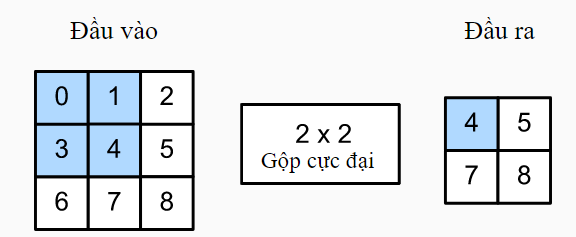

Mảng đầu ra ở hình phía trên có chiều cao là 2 và chiều rộng là 2. Bốn phần tử của nó được là các giá trị cực đại của hàm  max:
$$
\begin{split}\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\\end{split}$$

Một tầng gộp với cửa sổ gộp có kích thước $p×q$ được gọi là một tầng gộp $p×q$. Phép gộp sẽ được gọi là phép gộp  p×q.

Hãy cùng quay trở lại với ví dụ nhận diện biên của vật thể được đề cập ở đầu mục. Bây giờ, chúng ta sẽ sử dụng kết quả của tầng tích chập làm giá trị đầu vào cho tầng gộp cực đại $2×2$. Đặt giá trị đầu vào của tầng tích chập là X và kết quả của tầng gộp là Y. Dù giá trị của X[i, j] và X[i, j+1] hay giá trị của X[i, j+1] và X[i, j+2] có khác nhau hay không, tất cả giá trị trả về của tầng gộp sẽ là Y[i, j]=1. Nói cách khác, khi sử dụng tầng gộp cực đại $2×2$
 , ta vẫn có thể phát hiện ra khuôn mẫu được nhận diện bởi tầng tích chập nếu nó bị chuyển dịch không nhiều hơn một phần tử theo chiều cao và chiều rộng.

Trong đoạn mã bên dưới, ta lập trình lượt truyền xuôi của tầng gộp trong hàm pool2d. Hàm này khá giống với hàm corr2d trong Section 7.2. Tuy nhiên, hàm này không có bộ lọc nên kết quả đầu ra hoặc là giá trị lớn nhất, hoặc là giá trị trung bình tương ứng của mỗi vùng đầu vào.

In [3]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

Chúng ta có thể xây dựng mảng đầu vào X ở biểu đồ ở trên để kiểm tra giá trị kết quả của tầng gộp cực đại hai chiều.

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

Đồng thời, chúng ta cũng thực hiện thí nghiệm với tầng gộp trung bình.

In [5]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

# 7.5.2. Đệm và Sải bước
Cũng giống như các tầng tính chập, các tầng gộp cũng có thể thay đổi kích thước đầu ra. Và cũng như trước, chúng ta có thể thay đổi cách thức hoạt động của tầng gộp để đạt được kích thước đầu ra như mong muốn bằng cách thêm đệm vào đầu vào và điều chỉnh sải bước. Chúng ta có thể minh hoạ cách sử dụng đệm và sải bước trong các tầng gộp thông qua tầng gộp cực đại hai chiều MaxPool2D được cung cấp trong mô-đun nn của thư viện MXNet Gluon. Đầu tiên, chúng ta tạo ra dữ liệu đầu vào kích thước (1, 1, 4, 4), trong đó hai chiều đầu tiên lần lượt là kích thước batch và số kênh.

In [7]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Vì việc tổng hợp thông tin tổng hợp từ một khu vực, nên các khung học sâu mặc định phù hợp với kích thước và bước tiến của cửa sổ tổng hợp. Chẳng hạn, nếu chúng ta sử dụng một cửa sổ tổng hợp các hình dạng, chúng ta sẽ có được một hình dạng sải chân theo mặc định.(3, 3)(3, 3)

In [9]:
pool2d = nn.MaxPool2d(2)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

Như mong đợi, sải chân và phần đệm có thể được chỉ định theo cách thủ công để ghi đè các giá trị mặc định của khung nếu cần.

In [10]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

# 7.5.3. Nhiều kênh

Khi xử lý dữ liệu đầu vào đa kênh, tầng gộp sẽ áp dụng lên từng kênh một cách riêng biệt thay vì cộng từng phần tử tương ứng của các kênh lại với nhau như tầng tích chập. Điều này có nghĩa là số lượng kênh đầu ra của tầng gộp sẽ giống số lượng kênh đầu vào. Dưới đây, chúng ta sẽ ghép 2 mảng X và X+1 theo chiều kênh để tạo ra đầu vào 2 kênh.

In [11]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

Như chúng ta có thể thấy, số lượng kênh đầu ra vẫn là 2 sau khi gộp lại.

In [12]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])